In [72]:
import multiprocessing
import os
import re
import nltk
import gensim.models.word2vec as word2vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [20]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
dataset = "movie_review_dataset"

temp = []
for folder in os.listdir(dataset):
    folder = os.path.join(dataset, folder)
    if not folder.endswith(".txt"):
        for file in os.listdir(os.path.join(folder, 'pos')):
            with open(os.path.join(folder, 'pos', file), 'r', encoding='utf8') as f:
                text = f.read()
                temp.append([text, True, os.path.join(folder, 'pos', file)])

        for file in os.listdir(os.path.join(folder, 'neg')):
            with open(os.path.join(folder, 'neg', file), 'r', encoding='utf8') as f:
                text = f.read()
                temp.append([text, False, os.path.join(folder, 'neg', file)])

In [22]:
df = pd.DataFrame(temp,columns=['Review', 'Sentiment', 'File']) 
df.head()

,Review,Sentiment,File
0,I went and saw this movie last night after bei...,True,movie_review_dataset\part1\pos\0_10.txt
1,Actor turned director Bill Paxton follows up h...,True,movie_review_dataset\part1\pos\10000_7.txt
2,As a recreational golfer with some knowledge o...,True,movie_review_dataset\part1\pos\10001_9.txt
3,"I saw this film in a sneak preview, and it is ...",True,movie_review_dataset\part1\pos\10002_8.txt
4,Bill Paxton has taken the true story of the 19...,True,movie_review_dataset\part1\pos\10003_8.txt


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
Review       50000 non-null object
Sentiment    50000 non-null bool
File         50000 non-null object
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


In [24]:
df.describe(include='all')

,Review,Sentiment,File
count,50000,50000,50000
unique,49582,2,50000
top,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\11267_10.txt
freq,5,25000,1


In [25]:
df.loc[df['Review'].str.contains("Loved today's show!!!")]

,Review,Sentiment,File
6296,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\4417_10.txt
6297,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\4418_10.txt
6298,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\4419_10.txt
6300,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\4420_10.txt
6302,Loved today's show!!! It was a variety and not...,True,movie_review_dataset\part1\pos\4422_10.txt


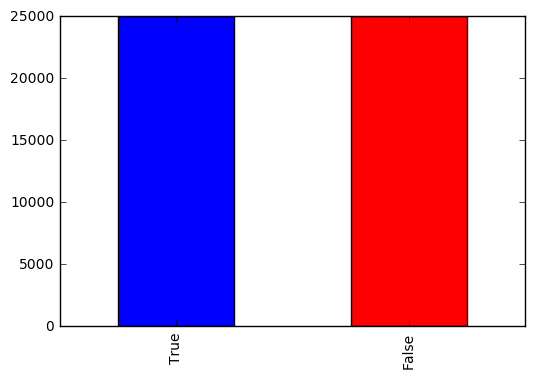

In [26]:
df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [29]:
corpus_raw = u""
i =0 
for review in df['Review']:
    if i % 1000 == 0:
        print(i)
    corpus_raw += review
    i+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [34]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)

In [31]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [37]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [39]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

This one did exactly that.
['This', 'one', 'did', 'exactly', 'that']


In [41]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 11,908,918 tokens


In [43]:
num_features = 50
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

word2vec_model = word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

word2vec_model.build_vocab(sentences)

In [47]:
print("Word2Vec vocabulary length:", word2vec_model.corpus_count)

Word2Vec vocabulary length: 488666


In [54]:
word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.iter)

45080838

In [65]:
if not os.path.exists("trained"):
    os.makedirs("trained")

word2vec_model.save(os.path.join("trained", "word2vec.w2v"))

In [66]:
word2vec_model = word2vec.Word2Vec.load(os.path.join("trained", "word2vec.w2v"))

In [69]:
word2vec_model.most_similar("bad")

[('terrible', 0.8803883790969849),
 ('lousy', 0.854094386100769),
 ('awful', 0.8529340028762817),
 ('horrible', 0.8415226936340332),
 ('sucks', 0.8255780935287476),
 ('stupid', 0.8225116729736328),
 ('lame', 0.8162035942077637),
 ('good', 0.8160144686698914),
 ('dumb', 0.8136780261993408),
 ('poor', 0.8047755360603333)]

In [71]:
word2vec_model.most_similar("good")

[('decent', 0.8786534667015076),
 ('great', 0.8691418170928955),
 ('ok', 0.8247650861740112),
 ('nice', 0.8221795558929443),
 ('OK', 0.8194639682769775),
 ('bad', 0.8160144686698914),
 ('fine', 0.8096367716789246),
 ('okay', 0.8009151220321655),
 ('alright', 0.799268364906311),
 ('cool', 0.792222797870636)]

### Referencias

https://www.youtube.com/watch?v=pY9EwZ02sXU&t=60s